In [30]:
import seaborn as sns
import pickle 


In [1]:
import pandas as pd
import numpy as np

In [2]:
pd.set_option('display.max_rows', 200)

In [3]:
year19_path_list=  ['turnstile_190504.txt', 'turnstile_190511.txt','turnstile_190518.txt','turnstile_190525.txt']

In [4]:
def load_data(list_of_datasets):
    year = pd.concat(map(lambda x: pd.read_csv(x,parse_dates=[['DATE','TIME']]), 
        list_of_datasets))
    return year

In [5]:
def preprocessing(dataframe):
    dataframe.reset_index(drop=True,inplace=True)
    dataframe.drop(['C/A','LINENAME','DIVISION', 'DESC'],axis=1,inplace = True)
    dataframe['UNIT/SCP']= dataframe['UNIT'] + dataframe['SCP'] #creating an ideantifier column 
    dataframe =  dataframe[(dataframe['DATE_TIME'].dt.month > 4)]
    dataframe = dataframe.sort_values(['STATION', 'UNIT/SCP','DATE_TIME'], ascending= True)
    return  dataframe
    

In [6]:
def calculate_entries_column(dataframe):
    dataframe.reset_index(drop=True,inplace=True)
    dataframe['ENTRIES_DIFF']=0
    for index, row in dataframe.iterrows():
        if index == 0:
            continue
        if row['UNIT/SCP'] == dataframe['UNIT/SCP'][index-1] and row['STATION'] == dataframe['STATION'][index-1] and row['ENTRIES'] > int(dataframe['ENTRIES'][index-1]):
            dataframe['ENTRIES_DIFF'][index] = row['ENTRIES'] - int(dataframe['ENTRIES'][index-1])
            
    return dataframe

In [7]:
def calculate_exits_column(dataframe):
    year19.columns=year19.columns.str.strip()
    dataframe.reset_index(drop=True,inplace=True)
    dataframe['EXITS_DIFF']=0
    for index, row in dataframe.iterrows():
        if index == 0:
            continue
        if row['UNIT/SCP'] == dataframe['UNIT/SCP'][index-1] and row['STATION'] == dataframe['STATION'][index-1] and row['EXITS'] > int(dataframe['EXITS'][index-1]):
            dataframe['EXITS_DIFF'][index] = row['EXITS'] - int(dataframe['EXITS'][index-1])
            
    return dataframe

In [8]:
def calculate_total_traffic(dataframe):
    dataframe['TOTAL_TRAFFIC']= dataframe['ENTRIES_DIFF'] + dataframe['EXITS_DIFF']
    return dataframe

In [9]:
def generate_stat(dataframe):
    year19_traffic_per_station = dataframe.groupby('STATION').TOTAL_TRAFFIC.sum()
    year19_traffic_per_station = pd.DataFrame(year19_traffic_per_station)
    sorted_traffic = year19_traffic_per_station.sort_values(by=['TOTAL_TRAFFIC'], ascending= False)
    return sorted_traffic

In [35]:
def pickle_df(dataframe):
    with open("MTA_19.pickle","wb")as to_write:
        pickle.dump(dataframe,to_write)

In [39]:
def read_pickle(file_name):
    with open(file_name, 'rb') as f:
        dataframe = pickle.load(f)
        return dataframe

In [10]:
year19=load_data(year19_path_list)

In [11]:
year19 = preprocessing(year19)

In [12]:
year19 = calculate_entries_column(year19)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [13]:
year19 = calculate_exits_column(year19)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [14]:
#HANDLING OUTLIERS 

In [15]:
year19['ENTRIES_DIFF'][81250] = 142

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [16]:
year19['ENTRIES_DIFF'][17616] = 142

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [17]:
year19['EXITS_DIFF'][81250] = 0

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [18]:
year19['EXITS_DIFF'][17616] = 0

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [19]:
year19 = calculate_total_traffic(year19)


In [36]:
pickle_df(year19)

In [37]:
!dir

 Volume in drive C is OS
 Volume Serial Number is D62A-B679

 Directory of C:\Users\queen\project-01

09/04/2019  05:20 PM    <DIR>          .
09/04/2019  05:20 PM    <DIR>          ..
09/04/2019  03:30 PM    <DIR>          .ipynb_checkpoints
09/04/2019  03:30 PM               100 importing-datasets.py
09/04/2019  05:18 PM        59,831,951 MTA_19
09/04/2019  05:20 PM        59,831,951 MTA_19.pickle
09/04/2019  05:19 PM            30,714 project-01.ipynb
09/03/2019  11:40 AM                12 README.md
09/04/2019  03:30 PM        26,042,412 turnstile_170506.txt
09/04/2019  03:30 PM        25,985,784 turnstile_170513.txt
09/04/2019  03:30 PM        25,802,832 turnstile_170520.txt
09/04/2019  03:30 PM        25,801,248 turnstile_170527.txt
09/04/2019  03:30 PM        26,030,796 turnstile_180505.txt
09/04/2019  03:30 PM        25,958,592 turnstile_180512.txt
09/04/2019  03:30 PM        25,968,888 turnstile_180519.txt
09/04/2019  03:30 PM        26,159,100 turnstile_180526.txt
09/04/2019  

In [40]:
year19_pickle = read_pickle('MTA_19.pickle')

In [41]:
year19_pickle

,DATE_TIME,UNIT,SCP,STATION,ENTRIES,EXITS,UNIT/SCP,ENTRIES_DIFF,EXITS_DIFF,TOTAL_TRAFFIC
0,2019-05-01 00:00:00,R248,00-00-00,1 AV,14654538,16381430,R24800-00-00,0,0,0
1,2019-05-01 04:00:00,R248,00-00-00,1 AV,14654538,16381436,R24800-00-00,0,6,6
2,2019-05-01 08:00:00,R248,00-00-00,1 AV,14654889,16382236,R24800-00-00,351,800,1151
3,2019-05-01 12:00:00,R248,00-00-00,1 AV,14656102,16383435,R24800-00-00,1213,1199,2412
4,2019-05-01 16:00:00,R248,00-00-00,1 AV,14656924,16384214,R24800-00-00,822,779,1601
...,...,...,...,...,...,...,...,...,...,...
705134,2019-05-24 05:00:00,R326,00-05-01,ZEREGA AV,39,148,R32600-05-01,0,0,0
705135,2019-05-24 09:00:00,R326,00-05-01,ZEREGA AV,39,148,R32600-05-01,0,0,0
705136,2019-05-24 13:00:00,R326,00-05-01,ZEREGA AV,39,148,R32600-05-01,0,0,0
705137,2019-05-24 17:00:00,R326,00-05-01,ZEREGA AV,39,148,R32600-05-01,0,0,0


In [20]:
year19

,DATE_TIME,UNIT,SCP,STATION,ENTRIES,EXITS,UNIT/SCP,ENTRIES_DIFF,EXITS_DIFF,TOTAL_TRAFFIC
0,2019-05-01 00:00:00,R248,00-00-00,1 AV,14654538,16381430,R24800-00-00,0,0,0
1,2019-05-01 04:00:00,R248,00-00-00,1 AV,14654538,16381436,R24800-00-00,0,6,6
2,2019-05-01 08:00:00,R248,00-00-00,1 AV,14654889,16382236,R24800-00-00,351,800,1151
3,2019-05-01 12:00:00,R248,00-00-00,1 AV,14656102,16383435,R24800-00-00,1213,1199,2412
4,2019-05-01 16:00:00,R248,00-00-00,1 AV,14656924,16384214,R24800-00-00,822,779,1601
...,...,...,...,...,...,...,...,...,...,...
705134,2019-05-24 05:00:00,R326,00-05-01,ZEREGA AV,39,148,R32600-05-01,0,0,0
705135,2019-05-24 09:00:00,R326,00-05-01,ZEREGA AV,39,148,R32600-05-01,0,0,0
705136,2019-05-24 13:00:00,R326,00-05-01,ZEREGA AV,39,148,R32600-05-01,0,0,0
705137,2019-05-24 17:00:00,R326,00-05-01,ZEREGA AV,39,148,R32600-05-01,0,0,0


In [21]:
stats = generate_stat(year19)

In [22]:
stats = stats.head(5)
stats

,TOTAL_TRAFFIC
STATION,
BAYCHESTER AV,2222752440
ST. GEORGE,2205188474
GUN HILL RD,1322140403
116 ST,1237834828
219 ST,1220116937


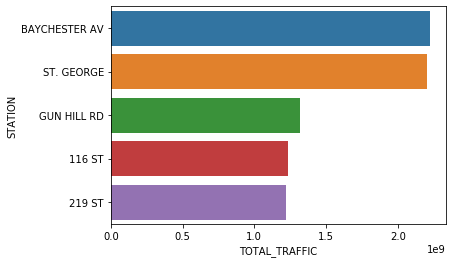

In [26]:
sns.barplot(x=stats['TOTAL_TRAFFIC'], y=stats['STATION'])

In [ ]:
sns.boxplot(x=stats['TOTAL_TRAFFIC'])

In [ ]:
stats.STATION

In [25]:
stats = stats.reset_index()
stats.columns

Index(['STATION', 'TOTAL_TRAFFIC'], dtype='object')

In [ ]:
year19_traffic_per_station = year19.groupby('STATION').TOTAL_TRAFFIC.sum()
year19_traffic_per_station